In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import toml
from utils.plotter import *


class SpikeAnalysis:
    def __init__(self, stimulus, spike_train, filter, config_file:str='config.toml'):
        with open(config_file, "r") as f:
            config = toml.load(f)

        self.stimulus = stimulus
        self.spike_train = spike_train
        self.filter = filter
        self.start = config["sta_parameters"]["start"]
        self.end = config["sta_parameters"]["end"]
        
        self._sanity_checks()
    
    def _sanity_checks(self) -> None:
        """
        Sanity check for the given stimulus, spike_train and 
        """
        if self.stimulus.ndim != 3:
            raise ValueError("Stimulus must be a 3D array: [height, width, time].")
        if len(self.spike_train) != self.stimulus.shape[2]:
            raise ValueError(f"spike_train length must match the third dimension (time) of stimulus: {len(self.spike_train)=} vs {len(self.stimulus[2])=}")
        if self.end < self.start:
            raise ValueError("End must be after start.")
        
    def sta(self) -> np.ndarray:
        """
        Calculates the simple spike triggered average (STA) in terms of lags. 
        """
        spikes, = np.where(self.spike_train == 1)
        if spikes.size == 0:
            raise ValueError('Found no spikes in the given spike train.')
        
        n_lags = self.end - self.start
        sta = np.zeros((self.stimulus.shape[0], self.stimulus.shape[1], n_lags))
        spike_count = 0

        for spike in spikes:
            window_start = spike + self.start
            window_end = spike + self.end
            if window_start < 0 or window_end > self.stimulus.shape[2]:
                print(f'Exceeding: {window_start} - {window_end}')
                continue

            for i_lag, time_point in enumerate(range(window_start, window_end)):
                sta[:, :, i_lag] += self.stimulus[:, :, time_point]
                
            spike_count += 1

        sta /= spike_count
        # sta -= sta.mean()  # Skipping this has actually given less noisy results
        # TODO: Get some metrics about noise and simulation length vs clarity of the sta
        
        for i_lag in range(n_lags): # And I think I have to do this
            sta[i_lag] -= sta[i_lag].mean()

        self.sta = sta
        return sta

In [7]:
data_dir = ''
gauss_spike_train = np.load(os.path.join(data_dir, 'spike_train_gauss_1.npy'))
gauss_stimulus = np.load(os.path.join(data_dir, 'stimulus_gauss_1.npy'))
gauss_filter = np.load(os.path.join(data_dir, f'filter_gauss_1.npy'))
gauss_stimulus = gauss_stimulus.transpose((1,2,0))

gabor_spike_train = np.load(os.path.join(data_dir, 'spike_train_gabor_1.npy'))
gabor_stimulus = np.load(os.path.join(data_dir, 'stimulus_gabor_1.npy'))
gabor_filter = np.load(os.path.join(data_dir, f'filter_gabor_1.npy'))
gabor_stimulus = gabor_stimulus.transpose((1,2,0))

ricker_spike_train = np.load(os.path.join(data_dir, 'spike_train_ricker_1.npy'))
ricker_stimulus = np.load(os.path.join(data_dir, 'stimulus_ricker_1.npy'))
ricker_filter = np.load(os.path.join(data_dir, f'filter_ricker_1.npy'))
ricker_stimulus = ricker_stimulus.transpose((1,2,0))

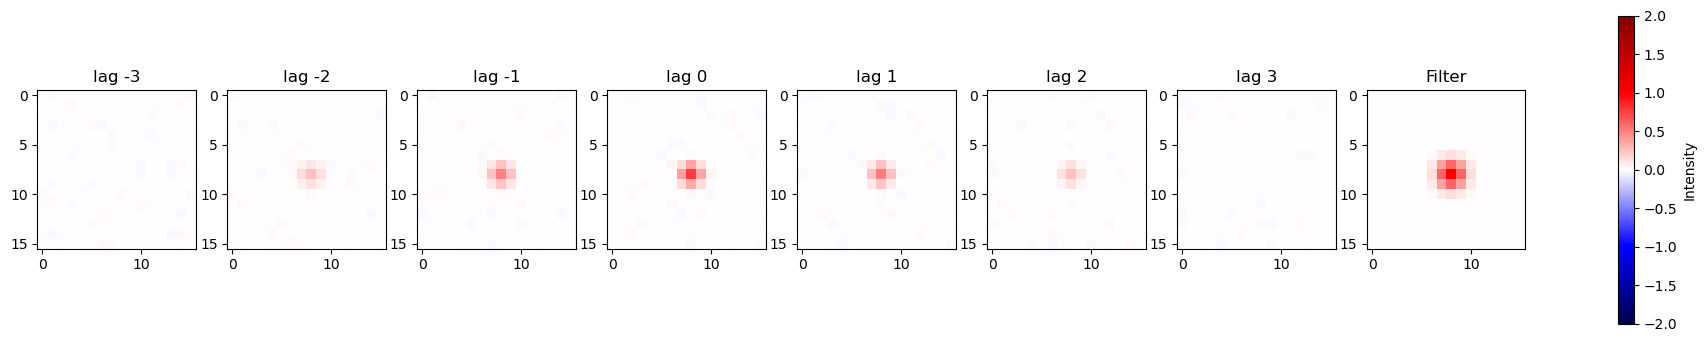

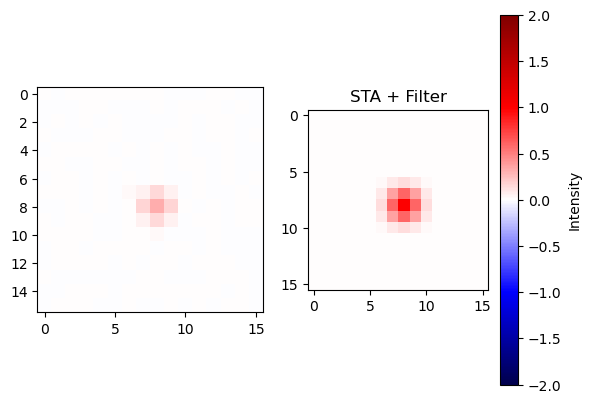

In [8]:
gauss = SpikeAnalysis(gauss_stimulus, gauss_spike_train, gauss_filter)
gauss.sta()
plot_simple_sta_lags(gauss.sta, gauss.filter, gauss.start, gauss.end)

plot_avg_sta_with_filter(gauss.sta, gauss.filter)

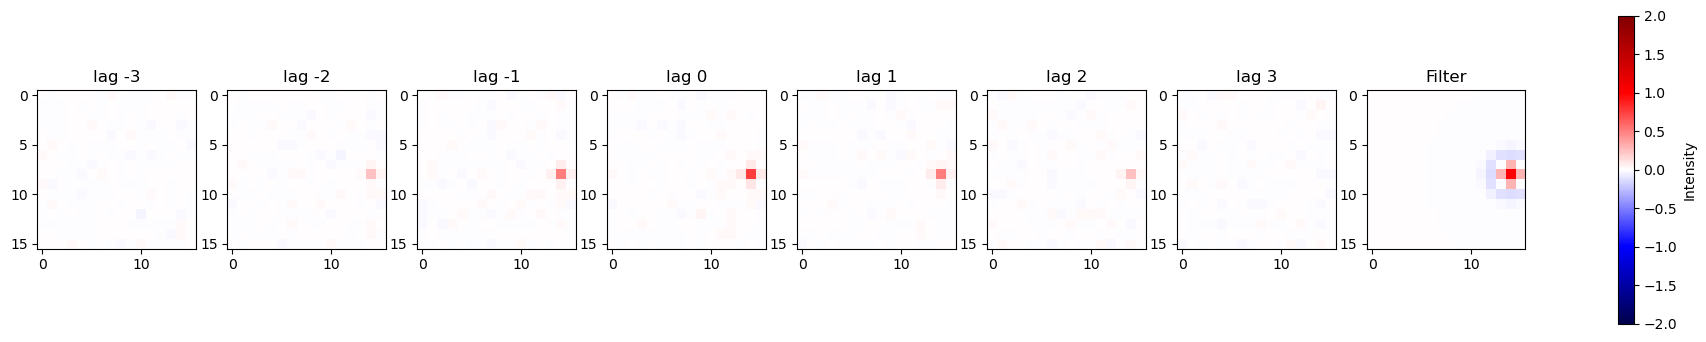

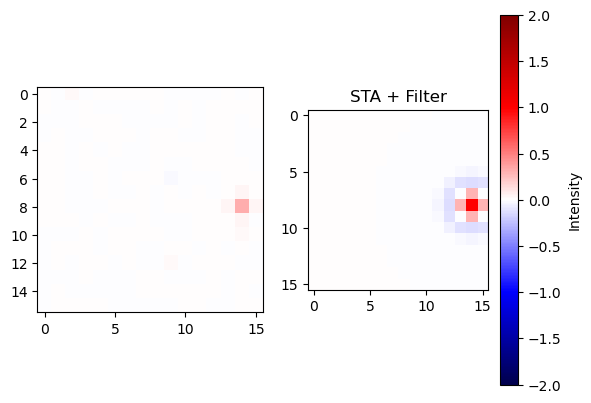

In [9]:
ricker = SpikeAnalysis(ricker_stimulus, ricker_spike_train, ricker_filter)
ricker.sta()
plot_simple_sta_lags(ricker.sta, ricker.filter, ricker.start, ricker.end)
plot_avg_sta_with_filter(ricker.sta, ricker.filter)


Exceeding: 999996 - 1000003
Exceeding: 999997 - 1000004
Exceeding: 999998 - 1000005


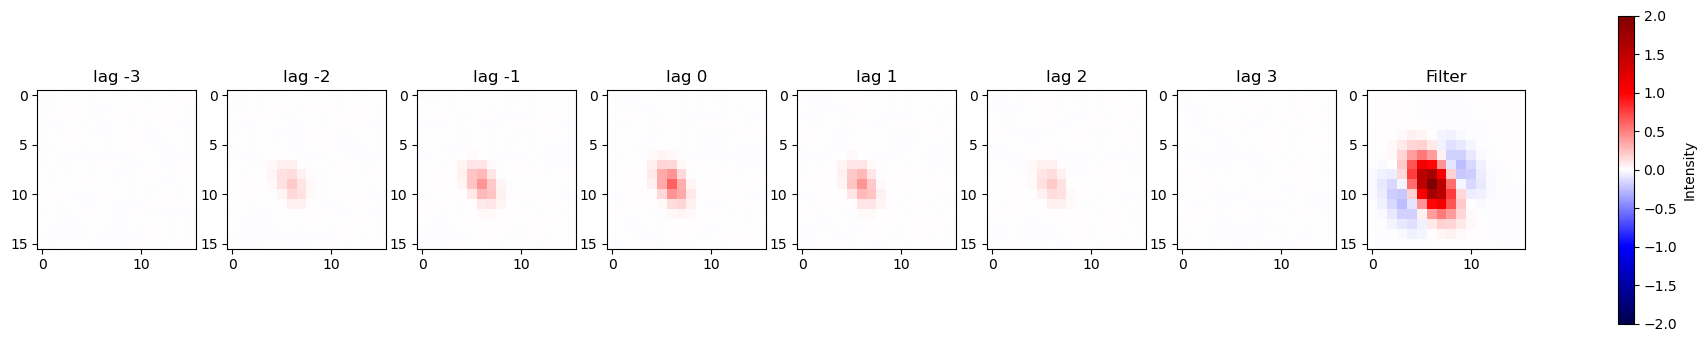

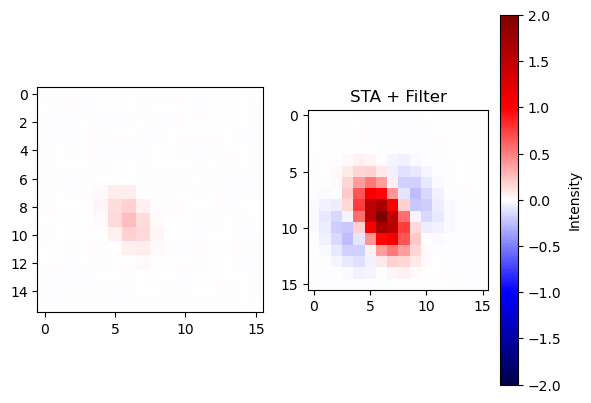

In [11]:
gabor = SpikeAnalysis(gabor_stimulus, gabor_spike_train, gabor_filter)
gabor.sta()
plot_simple_sta_lags(gabor.sta, gabor.filter, gabor.start, gabor.end)
plot_avg_sta_with_filter(gabor.sta, gabor.filter)


In [ ]:
mse = np.mean((gauss_sta - gauss_filter)**2)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0082
